In [1]:
#please uncomment the following if needed
! pip install torch torchvision
! pip install matplotlib
! pip install opencv-contrib-python
! pip install imutils
! pip install scikit-learn
! pip install tqdm
! pip install rasterio
! pip install geopandas

In [2]:
# import the necessary packages
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np
from rasterio.plot import reshape_as_raster, reshape_as_image
import pandas as pd
import matplotlib.pyplot as plt
from rasterio.plot import show
import cv2
import pickle
import torch
import os
from torch.utils.data import Dataset
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
import torch
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
from tqdm import tqdm
import time

In [3]:
#read data from google drive,
#can also find it in https://www.kaggle.com/datasets/stanleydil/e4e-jamaica-segmentation-dataset by read from kaggle
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#read data from google drive by first upload the dataset to My Drive,
#can also find it in https://www.kaggle.com/datasets/stanleydil/e4e-jamaica-segmentation-dataset by read from kaggle
with open('/content/drive/My Drive/128px_images.pkl', 'rb') as handle:
    images = pickle.load(handle)

with open('/content/drive/My Drive/128px_labels.pkl', 'rb') as handle:
    labels = pickle.load(handle)

with open('/content/drive/My Drive/128_mlabels.pkl', 'rb') as handle:
    m_tiles = pickle.load(handle)

Config

In [5]:
TEST_SPLIT = 0.15
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False
# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CHANNELS = 9
NUM_CLASSES = 1
NUM_LEVELS = 3
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.001
NUM_EPOCHS = 40
BATCH_SIZE = 64
# define the input image dimensions
INPUT_IMAGE_WIDTH = 128 #or 256
INPUT_IMAGE_HEIGHT = 128
# define threshold to filter weak predictions
THRESHOLD = 0.5
# define the path to the base output directory
BASE_OUTPUT = "output"
# define the path to the output serialized model, model training
# plot, and testing image paths
# MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_mangrove.pth")
# PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
# TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

Dataset

In [6]:
class SegmentationDataset(Dataset):
  def __init__(self, images, labels, transforms):
    # store the image and mask filepaths, and augmentation
		# transforms
    self.transforms = transforms
    self.images = images
    self.labels = labels
  def __len__(self):
    # return the number of total samples contained in the dataset
    return np.array(self.images).shape[0]
  def __getitem__(self, idx):
    try:
      image = self.images[idx]
      mask = self.labels[idx]
    except:
      print ("no index at", idx)
    #image = self.images[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		# check to see if we are applying any transformations
      if self.transforms is not None:
			# apply the transformations to both image and its mask
        image = self.transforms(image)
        mask = self.transforms(mask)
		# return a tuple of the image and its mask
    return (image, mask)

Model

In [7]:
class Block(Module):
  def __init__(self, inChannels, outChannels):
    super().__init__()
		# store the convolution and RELU layers
    self.conv1 = Conv2d(inChannels, outChannels, 3)
    self.relu = ReLU()
    self.conv2 = Conv2d(outChannels, outChannels, 3)
  def forward(self, x):
		# apply CONV => RELU => CONV block to the inputs and return it
    return self.conv2(self.relu(self.conv1(x)))

In [8]:
class Encoder(Module):
  def __init__(self, channels=(9, 16, 32, 64)):
    super().__init__()
    # store the encoder blocks and maxpooling layer
    self.encBlocks = ModuleList(
        [Block(channels[i], channels[i + 1])
        for i in range(len(channels) - 1)])
    self.pool = MaxPool2d(2)
  def forward(self, x):
		# initialize an empty list to store the intermediate outputs
    blockOutputs = []
		# loop through the encoder blocks
    for block in self.encBlocks:
			# pass the inputs through the current encoder block, store
			# the outputs, and then apply maxpooling on the output
      x = block(x)
      blockOutputs.append(x)
      x = self.pool(x)
		# return the list containing the intermediate outputs
    return blockOutputs

In [9]:
class Decoder(Module):
  def __init__(self, channels=(64, 32, 16)):
    super().__init__()
		# initialize the number of channels, upsampler blocks, and
		# decoder blocks
    self.channels = channels
    self.upconvs = ModuleList(
        [ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
        for i in range(len(channels) - 1)])
    self.dec_blocks = ModuleList(
        [Block(channels[i], channels[i + 1])
        for i in range(len(channels) - 1)])
  def forward(self, x, encFeatures):
		# loop through the number of channels
    for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
      x = self.upconvs[i](x)
			# crop the current features from the encoder blocks,
			# concatenate them with the current upsampled features,
			# and pass the concatenated output through the current
			# decoder block
      encFeat = self.crop(encFeatures[i], x)
      x = torch.cat([x, encFeat], dim=1)
      x = self.dec_blocks[i](x)
		# return the final decoder output
    return x
  def crop(self, encFeatures, x):
		# grab the dimensions of the inputs, and crop the encoder
		# features to match the dimensions
    (_, _, H, W) = x.shape
    encFeatures = CenterCrop([H, W])(encFeatures)
		# return the cropped features
    return encFeatures

In [10]:
class UNet(Module):
  def __init__(self, encChannels=(9, 16, 32, 64), #9 channels since 9 features
               decChannels=(64, 32, 16),
               nbClasses=1, retainDim=True, #one channel for binary be thresholding
               outSize=(INPUT_IMAGE_HEIGHT,  INPUT_IMAGE_WIDTH)):
    super().__init__()
		# initialize the encoder and decoder
    self.encoder = Encoder(encChannels)
    self.decoder = Decoder(decChannels)
		# initialize the regression head and store the class variables
    self.head = Conv2d(decChannels[-1], nbClasses, 1)
    self.retainDim = retainDim
    self.outSize = outSize
  def forward(self, x):
		# grab the features from the encoder
    encFeatures = self.encoder(x)
		# pass the encoder features through decoder making sure that
		# their dimensions are suited for concatenation
    decFeatures = self.decoder(encFeatures[::-1][0],
                               encFeatures[::-1][1:])
		# pass the decoder features through the regression head to
		# obtain the segmentation mask
    map = self.head(decFeatures)
		# check to see if we are retaining the original output
		# dimensions and if so, then resize the output to match them
    if self.retainDim:
      map = F.interpolate(map, self.outSize)
		# return the segmentation map
    return map

Train

In [11]:
# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing
split = train_test_split(images, labels, #images, labels,
                         test_size=TEST_SPLIT, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]
# define transformations
transforms = transforms.Compose([transforms.ToPILImage(),
                                 transforms.Resize((INPUT_IMAGE_HEIGHT,
                                                    INPUT_IMAGE_WIDTH)),
                                 transforms.ToTensor()])
# create the train and test datasets
trainDS = SegmentationDataset(images=trainImages, labels=trainMasks, transforms = None)
                              #transforms=transforms)
testDS = SegmentationDataset(images=testImages, labels=testMasks, transforms = None)
                             #transforms=transforms)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders #config
trainLoader = DataLoader(trainDS, shuffle=True,
                         batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
                         num_workers=os.cpu_count())
testLoader = DataLoader(testDS, shuffle=False,
                        batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
                        num_workers=os.cpu_count())
# initialize our UNet model #config
unet = UNet().to(DEVICE)
# initialize loss function and optimizer
lossFunc = BCEWithLogitsLoss()
opt = Adam(unet.parameters(), lr=INIT_LR)
# calculate steps per epoch for training and test set #config
trainSteps = len(trainDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

[INFO] found 3478 examples in the training set...
[INFO] found 614 examples in the test set...


In [12]:
# loop over epochs #config
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(NUM_EPOCHS)):
	# set the model in training mode
  unet.train()

	# initialize the total training and validation loss
  totalTrainLoss = 0
  totalTestLoss = 0

	# loop over the training set
  for (i, (x, y)) in enumerate(trainLoader):
		# send the input to the device
    x = np.transpose(x, (0, 3, 1, 2))
    y = np.transpose(y, (0, 3, 1, 2))
    (x, y) = (x.to(DEVICE), y.to(DEVICE)) #config

		# perform a forward pass and calculate the training loss
    #print(x.shape)
    pred = unet(x)
    loss = lossFunc(pred, y)

		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
    opt.zero_grad()
    loss.backward()
    opt.step()

		# add the loss to the total training loss so far
    totalTrainLoss += loss

	# switch off autograd
  with torch.no_grad():
		# set the model in evaluation mode
    unet.eval()

		# loop over the validation set
    for (x, y) in testLoader:
			# send the input to the device
      x = np.transpose(x, (0, 3, 1, 2))
      y = np.transpose(y, (0, 3, 1, 2))
      (x, y) = (x.to(DEVICE), y.to(DEVICE)) #config

			# make the predictions and calculate the validation loss

      pred = unet(x)
      totalTestLoss += lossFunc(pred, y)

	# calculate the average training and validation loss
  avgTrainLoss = totalTrainLoss / trainSteps
  avgTestLoss = totalTestLoss / testSteps

	# update our training history
  H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
  H["test_loss"].append(avgTestLoss.cpu().detach().numpy())

	# print the model training and validation information
  print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS)) #config
  print("Train loss: {:.6f}, Test loss: {:.4f}".format(
      avgTrainLoss, avgTestLoss))

[INFO] training the network...


  2%|▎         | 1/40 [00:16<10:39, 16.41s/it]

[INFO] EPOCH: 1/40
Train loss: 0.231401, Test loss: 0.2019


  5%|▌         | 2/40 [00:27<08:18, 13.13s/it]

[INFO] EPOCH: 2/40
Train loss: 0.192036, Test loss: 0.1933


  8%|▊         | 3/40 [00:35<06:50, 11.10s/it]

[INFO] EPOCH: 3/40
Train loss: 0.172945, Test loss: 0.1745


 10%|█         | 4/40 [00:43<05:49,  9.72s/it]

[INFO] EPOCH: 4/40
Train loss: 0.164730, Test loss: 0.1588


 12%|█▎        | 5/40 [00:51<05:12,  8.94s/it]

[INFO] EPOCH: 5/40
Train loss: 0.158748, Test loss: 0.1645


 15%|█▌        | 6/40 [00:58<04:45,  8.39s/it]

[INFO] EPOCH: 6/40
Train loss: 0.154307, Test loss: 0.1483


 18%|█▊        | 7/40 [01:06<04:28,  8.14s/it]

[INFO] EPOCH: 7/40
Train loss: 0.155842, Test loss: 0.1609


 20%|██        | 8/40 [01:13<04:12,  7.91s/it]

[INFO] EPOCH: 8/40
Train loss: 0.147962, Test loss: 0.1419


 22%|██▎       | 9/40 [01:21<04:02,  7.82s/it]

[INFO] EPOCH: 9/40
Train loss: 0.140714, Test loss: 0.1379


 25%|██▌       | 10/40 [01:28<03:52,  7.75s/it]

[INFO] EPOCH: 10/40
Train loss: 0.137553, Test loss: 0.1368


 28%|██▊       | 11/40 [01:36<03:44,  7.75s/it]

[INFO] EPOCH: 11/40
Train loss: 0.140057, Test loss: 0.1339


 30%|███       | 12/40 [01:44<03:39,  7.83s/it]

[INFO] EPOCH: 12/40
Train loss: 0.136117, Test loss: 0.1409


 32%|███▎      | 13/40 [01:52<03:29,  7.76s/it]

[INFO] EPOCH: 13/40
Train loss: 0.136500, Test loss: 0.1348


 35%|███▌      | 14/40 [02:00<03:26,  7.93s/it]

[INFO] EPOCH: 14/40
Train loss: 0.133782, Test loss: 0.1328


 38%|███▊      | 15/40 [02:07<03:15,  7.84s/it]

[INFO] EPOCH: 15/40
Train loss: 0.130380, Test loss: 0.1295


 40%|████      | 16/40 [02:15<03:07,  7.82s/it]

[INFO] EPOCH: 16/40
Train loss: 0.130673, Test loss: 0.1575


 42%|████▎     | 17/40 [02:23<02:57,  7.71s/it]

[INFO] EPOCH: 17/40
Train loss: 0.134298, Test loss: 0.1289


 45%|████▌     | 18/40 [02:30<02:48,  7.68s/it]

[INFO] EPOCH: 18/40
Train loss: 0.126130, Test loss: 0.1303


 48%|████▊     | 19/40 [02:38<02:39,  7.60s/it]

[INFO] EPOCH: 19/40
Train loss: 0.125714, Test loss: 0.1274


 50%|█████     | 20/40 [02:45<02:31,  7.59s/it]

[INFO] EPOCH: 20/40
Train loss: 0.128204, Test loss: 0.1280


 52%|█████▎    | 21/40 [02:53<02:23,  7.54s/it]

[INFO] EPOCH: 21/40
Train loss: 0.124277, Test loss: 0.1309


 55%|█████▌    | 22/40 [03:00<02:16,  7.56s/it]

[INFO] EPOCH: 22/40
Train loss: 0.123473, Test loss: 0.1231


 57%|█████▊    | 23/40 [03:08<02:10,  7.65s/it]

[INFO] EPOCH: 23/40
Train loss: 0.124506, Test loss: 0.1251


 60%|██████    | 24/40 [03:16<02:01,  7.62s/it]

[INFO] EPOCH: 24/40
Train loss: 0.137709, Test loss: 0.1270


 62%|██████▎   | 25/40 [03:24<01:56,  7.73s/it]

[INFO] EPOCH: 25/40
Train loss: 0.131253, Test loss: 0.1299


 65%|██████▌   | 26/40 [03:31<01:47,  7.67s/it]

[INFO] EPOCH: 26/40
Train loss: 0.126694, Test loss: 0.1254


 68%|██████▊   | 27/40 [03:39<01:39,  7.65s/it]

[INFO] EPOCH: 27/40
Train loss: 0.126527, Test loss: 0.1382


 70%|███████   | 28/40 [03:46<01:31,  7.61s/it]

[INFO] EPOCH: 28/40
Train loss: 0.131868, Test loss: 0.1315


 72%|███████▎  | 29/40 [03:54<01:23,  7.60s/it]

[INFO] EPOCH: 29/40
Train loss: 0.127546, Test loss: 0.1291


 75%|███████▌  | 30/40 [04:01<01:15,  7.55s/it]

[INFO] EPOCH: 30/40
Train loss: 0.124613, Test loss: 0.1451


 78%|███████▊  | 31/40 [04:09<01:08,  7.56s/it]

[INFO] EPOCH: 31/40
Train loss: 0.131408, Test loss: 0.1231


 80%|████████  | 32/40 [04:17<01:01,  7.63s/it]

[INFO] EPOCH: 32/40
Train loss: 0.123979, Test loss: 0.1213


 82%|████████▎ | 33/40 [04:24<00:53,  7.60s/it]

[INFO] EPOCH: 33/40
Train loss: 0.121630, Test loss: 0.1315


 85%|████████▌ | 34/40 [04:32<00:46,  7.70s/it]

[INFO] EPOCH: 34/40
Train loss: 0.120121, Test loss: 0.1193


 88%|████████▊ | 35/40 [04:40<00:38,  7.65s/it]

[INFO] EPOCH: 35/40
Train loss: 0.123650, Test loss: 0.1206


 90%|█████████ | 36/40 [04:48<00:31,  7.93s/it]

[INFO] EPOCH: 36/40
Train loss: 0.121129, Test loss: 0.1188


 92%|█████████▎| 37/40 [04:56<00:23,  7.84s/it]

[INFO] EPOCH: 37/40
Train loss: 0.123751, Test loss: 0.1194


 95%|█████████▌| 38/40 [05:03<00:15,  7.74s/it]

[INFO] EPOCH: 38/40
Train loss: 0.119084, Test loss: 0.1210


 98%|█████████▊| 39/40 [05:11<00:07,  7.64s/it]

[INFO] EPOCH: 39/40
Train loss: 0.132728, Test loss: 0.1534


100%|██████████| 40/40 [05:18<00:00,  7.97s/it]

[INFO] EPOCH: 40/40
Train loss: 0.137712, Test loss: 0.1292


In [13]:
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
    endTime - startTime))

[INFO] total time taken to train the model: 318.91s


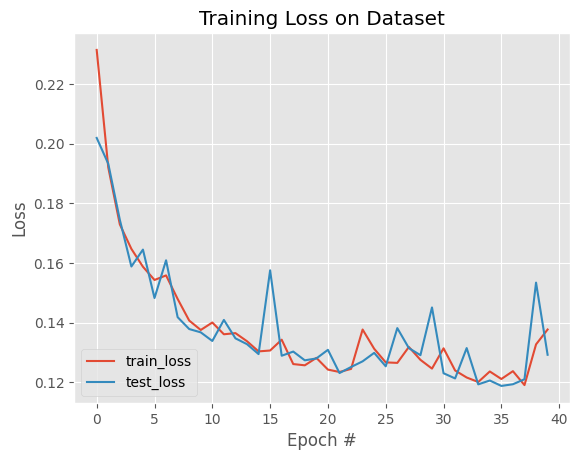

In [14]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
#plt.savefig(PLOT_PATH) #config

Predict

In [15]:
def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
  figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
  feature_num = 0 #can modify this to see different feature
  #ax[0].imshow(origImage[:,:,feature_num])
  ax[0].imshow(origMask)
  ax[1].imshow(predMask)

	# set the titles of the subplots
  ax[0].set_title("Original Mask")
  ax[1].set_title("Predicted Mask")

	# set the layout of the figure and display it
  figure.tight_layout()
  figure.show()

In [16]:
def prepare_plot_with_one_feature(origImage, origMask, predMask, feature_num = 0): #can modify feature_num to see different feature
	# initialize our figure
  figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
  ax[0].imshow(origImage[:,:,feature_num])
  ax[1].imshow(origMask)
  ax[2].imshow(predMask)

	# set the titles of the subplots
  ax[0].set_title("Image of feature"+str(feature_num))
  ax[1].set_title("Original Mask")
  ax[2].set_title("Predicted Mask")

	# set the layout of the figure and display it
  figure.tight_layout()
  figure.show()

In [17]:
def prepare_plot_with_all_features(origImage, origMask, predMask):
	# initialize our figure
  figure, ax = plt.subplots(nrows=3, ncols=4, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
  feature_num = 0 #can modify this to see different feature
  #ax[0].imshow(origImage[:,:,feature_num])
  ax[0, 0].imshow(origMask)
  ax[0, 1].imshow(predMask)
  for feature_num in range(2, 11):
    ax[int(feature_num//4), int(feature_num%4)].imshow(origImage[:,:,feature_num-2])

	# set the titles of the subplots
  ax[0, 0].set_title("Original Mask")
  ax[0, 1].set_title("Predicted Mask")
  for feature_num in range(2, 11):
    ax[int(feature_num//4), int(feature_num%4)].set_title("Image of feature"+str(feature_num-2))

	# set the layout of the figure and display it
  figure.tight_layout()
  figure.show()

In [18]:
#def make_predictions(model, imagePath):
def make_predictions(model, image_idx):
#def make_predictions(model, image_1, mask_1):
	# set model to evaluation mode
  model.eval()

	# turn off gradient tracking
  with torch.no_grad():
		# load the image from disk, swap its color channels, cast it
		# to float data type, and scale its pixel values
    image = images[image_idx]

		# resize the image and make a copy of it for visualization
    #image = cv2.resize(image, (128, 128))
    orig = image.copy()

		# find the filename and generate the path to ground truth
		# mask

		# load the ground-truth segmentation mask in grayscale mode
		# and resize it
    gtMask = labels[image_idx] #in grayscale?
    gtMask = cv2.resize(gtMask, (INPUT_IMAGE_HEIGHT, #config
                                 INPUT_IMAGE_HEIGHT)) #config
    #print(np.array(gtMask.flatten()).sum())

		# make the channel axis to be the leading one, add a batch
		# dimension, create a PyTorch tensor, and flash it to the
		# current device
    image = np.transpose(image, (2, 0, 1))
    #print(image.shape)
    #image = np.expand_dims(image, 0)
    image = np.array([image])
    image = torch.from_numpy(image).to(DEVICE) #config
    #print(image.shape)
		# make the prediction, pass the results through the sigmoid
		# function, and convert the result to a NumPy array

		# filter out the weak predictions and convert them to integers
    #predMask = (predMask > thres)* 255 #config
    predMask = model(image).detach().cpu().numpy() > 0
    predMask = predMask[0][0]
    #predMask = predMask.astype(np.uint8)
		# prepare a plot for visualization
    prepare_plot_with_one_feature(orig, gtMask, predMask)
    return predMask

Draft for testing

In [19]:
exp = images[m_tiles[50]]
exp = np.transpose(exp, (2, 0, 1))
exp = np.array([exp])
exp = torch.from_numpy(exp).to(DEVICE)

In [20]:
exp.shape

torch.Size([1, 9, 128, 128])

In [21]:
pred_exp = unet(exp).detach().cpu().numpy() > 0

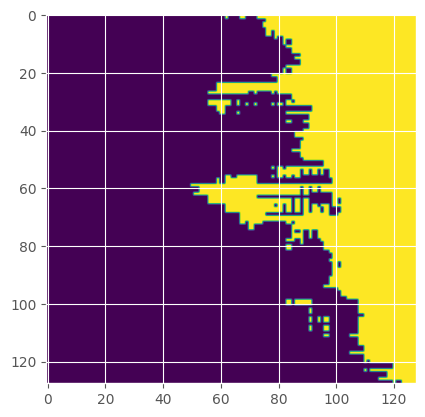

<Axes: >

In [22]:
show(pred_exp)

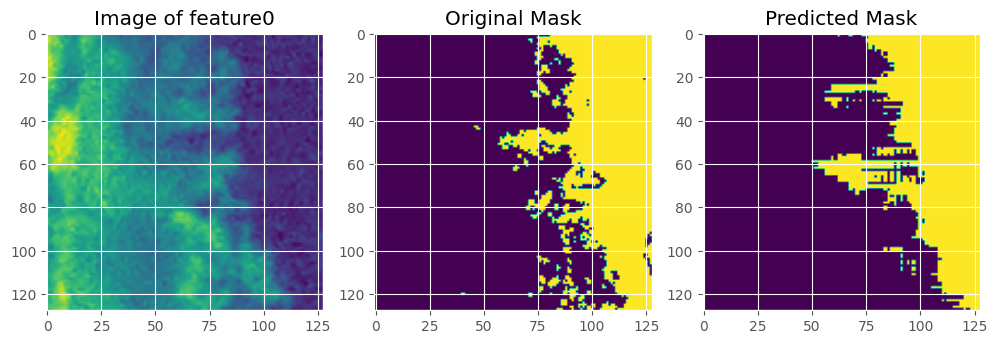

In [23]:
b_new= make_predictions(unet, m_tiles[50])

array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

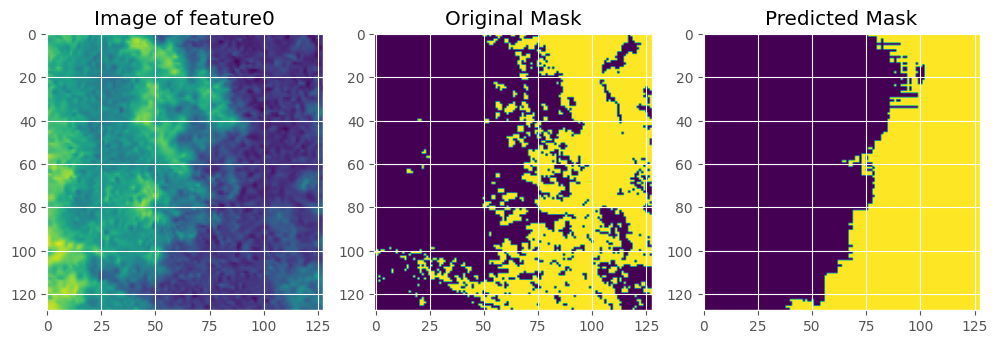

In [24]:
make_predictions(unet, m_tiles[62])

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

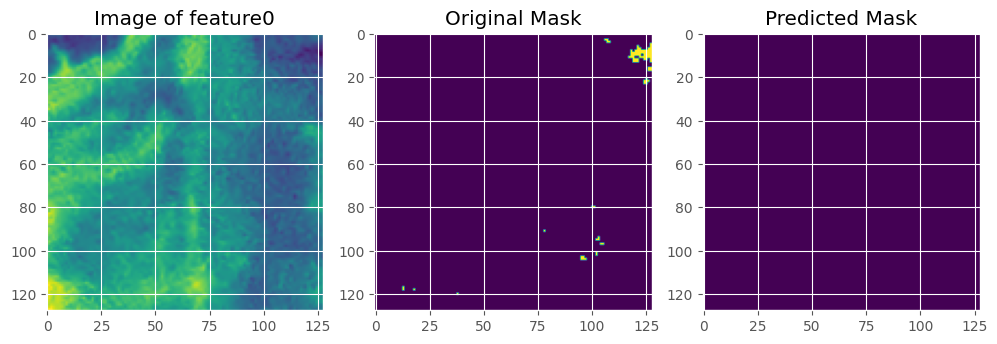

In [32]:
make_predictions(unet, m_tiles[30])

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

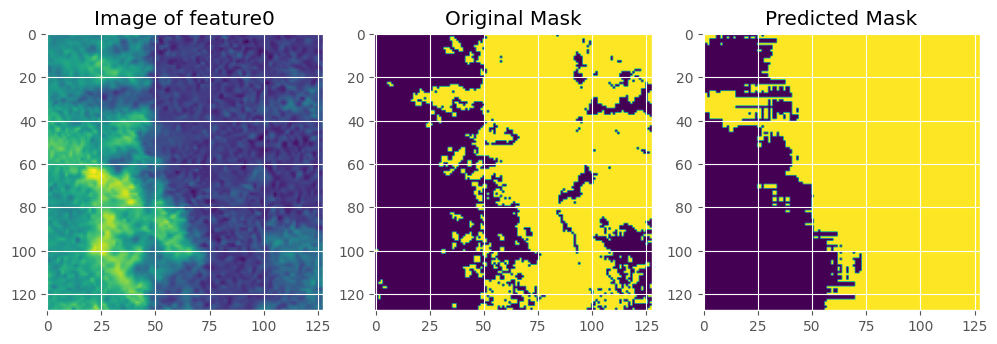

In [34]:
make_predictions(unet, m_tiles[68])

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

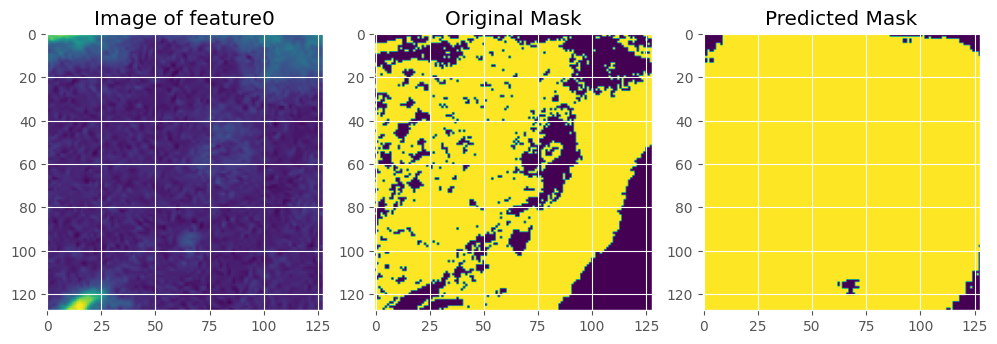

In [25]:
make_predictions(unet, 3984)

In [26]:
# load the image paths in our testing file and randomly select 10
# image paths
# print("[INFO] loading up test image paths...")
# imagePaths = open(TEST_PATHS).read().strip().split("\n") #config
# imagePaths = np.random.choice(imagePaths, size=10)

In [27]:
# # load our model from disk and flash it to the current device
# print("[INFO] load up model...")
# unet = torch.load(config.MODEL_PATH).to(config.DEVICE) #config

In [28]:
# # iterate over the randomly selected test image paths
# for path in imagePaths:
#   # make predictions and visualize the results
#   make_predictions(unet, path)